In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
plt.style.use('seaborn')

In [15]:
# features to read in to pandas DF
features = ['id',
            'last_scraped',
            'host_since',
            'host_response_time',
            'host_response_rate',
            'host_is_superhost',
            'host_total_listings_count',
            'host_has_profile_pic',
            'host_identity_verified',
            'latitude',
            'longitude',
            'property_type',
            'room_type',
            'accommodates',
            'bathrooms',
            'bedrooms',
            'beds',
            'bed_type',
            'price',
            'security_deposit',
            'cleaning_fee',
            'guests_included',
            'extra_people',
            'minimum_nights',
            'maximum_nights',
            'availability_30',
            'availability_60',
            'availability_90',
            'availability_365',
            'number_of_reviews',
            'number_of_reviews_ltm',
            'first_review',
            'last_review',
            'review_scores_rating',
            'review_scores_accuracy',
            'review_scores_cleanliness',
            'review_scores_checkin',
            'review_scores_communication',
            'review_scores_location',
            'review_scores_value',
            'instant_bookable',
            'is_business_travel_ready',
            'cancellation_policy',
            'require_guest_profile_picture',
            'require_guest_phone_verification',
            'calculated_host_listings_count',
            'reviews_per_month']

In [16]:
raw_data = pd.read_csv('data/listings.csv', true_values=['t'], false_values=['f'], usecols=features,
                 parse_dates=['last_scraped', 'host_since', 'first_review', 'last_review'])

In [17]:
def clean_data(raw_data):  
    """Clean entire dataset and prepare for modeling"""
    df = raw_data.copy()
    
    # Decrease dimensionality of property_type and bed_type features
    df.property_type = df.property_type.map(lambda x: x if x in ['House', 'Apartment', 'Condominium', 'Townhouse'] else 'Other')
    df.bed_type = df.bed_type.map(lambda x: x if x == 'Real Bed' else 'Other')
    
    # convert currencies to floats
    currency_cols = ['price', 'extra_people', 'security_deposit', 'cleaning_fee']
    for col in currency_cols:
        df[col] = df[col].astype(str)
        df[col] = df[col].map(lambda x: float(x.replace('$', '').replace(',', '')))
    
    # standardize availabilty features
    df.availability_30 = df.availability_30 / 30.
    df.availability_60 = df.availability_60 / 60.
    df.availability_90 = df.availability_90 / 90.
    df.availability_365 = df.availability_365 / 365.
    
    # convert rates and time differences to floats
    df['host_response_rate'] = df['host_response_rate'].str.replace('%', '.0').astype('float') / 100.0
    df['years_host_since'] = (df['last_scraped'] - df['host_since']) / np.timedelta64(1, 'Y')
    df['days_since_first_review'] = (df['last_scraped'] - df['first_review']) / np.timedelta64(1, 'D')
    df['days_since_last_review'] = (df['last_scraped'] - df['last_review']) / np.timedelta64(1, 'D')
    
    # convert True and False values to 1s and 0s
    df = df.replace(True, 1.).replace(False, 0.)
    
    # create dummy variables for categorical features 
    categorical_features = ['host_response_time',
                            'property_type',
                            'room_type',
                            'bed_type',
                            'cancellation_policy']
    df = pd.get_dummies(df, columns=categorical_features)
    
    # drop unnecessary columns and observations with NA values
    df.drop(['id', 'last_scraped', 'host_since', 'first_review', 'last_review'], axis=1, inplace=True)
    df = df.astype('float')
    df.dropna(inplace=True)
    
    # remove price outliers (keep middle 95%)
    quantiles = np.quantile(df.price, [0.025, 0.975])
    df = df.loc[(df.price > quantiles[0]) & (df.price < quantiles[1])]
    
    return df

In [18]:
df = clean_data(raw_data)
#df.to_csv('data/clean_data.csv')

In [19]:
df.price.describe()

count    4958.000000
mean      224.998386
std       197.397135
min        46.000000
25%        99.000000
50%       152.000000
75%       259.750000
max      1000.000000
Name: price, dtype: float64

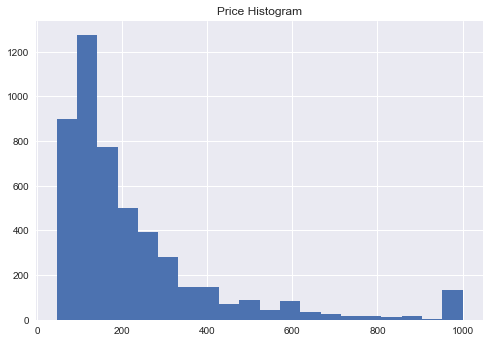

In [20]:
plt.hist(df.price, bins=20)
plt.title('Price Histogram')
plt.show()

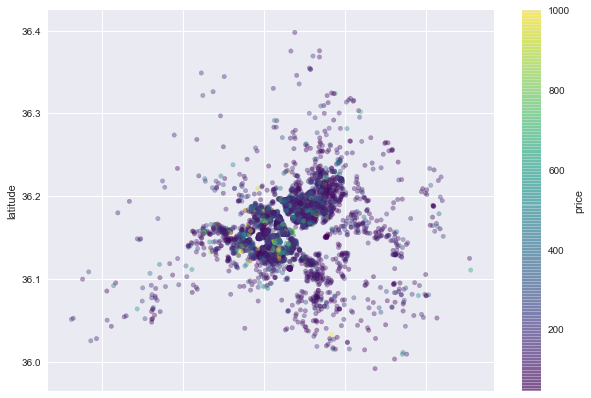

In [21]:
df.plot(kind="scatter", x="longitude", y="latitude",
    c="price", cmap=plt.get_cmap("viridis"),
    colorbar=True, alpha=0.4, figsize=(10,7),
)
plt.show()

#  Regression

In [22]:
def evaluate(model, X_test, y_test):
    y_pred = model.predict(X_test)
    errors = abs(y_pred - y_test)
    sse = sum((y_pred - y_test)**2)
    mse = np.mean((y_pred - y_test)**2)
    mape = 100 * np.mean(errors / y_test)
    accuracy = 100 - mape
    print('Test R^2: {:0.3f}'.format(model.score(X_test, y_test)))
    print('MAE: ${:0.2f}'.format(np.mean(errors)))
    print('MAPE: {:0.2f}%'.format(mape))
    print('SSE: {:0.2f}'.format(sse))
    print('MSE: {:0.2f}'.format(mse))
    print('Accuracy = {:0.2f}%'.format(accuracy))

In [23]:
X = df.drop('price', axis=1)
y = df['price']

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## OLS

In [25]:
lr = LinearRegression()
lr.fit(X_train, y_train)
evaluate(lr, X_test, y_test)

Test R^2: 0.511
MAE: $86.93
MAPE: 49.09%
SSE: 25738770.64
MSE: 17297.56
Accuracy = 50.91%


## Ridge

In [26]:
ridge_cv = RidgeCV(cv=20)
ridge_cv.fit(X_train, y_train)
evaluate(ridge_cv, X_test, y_test)

Test R^2: 0.510
MAE: $86.95
MAPE: 49.07%
SSE: 25770703.29
MSE: 17319.02
Accuracy = 50.93%


## Lasso

In [27]:
lasso_cv = LassoCV(cv=20, random_state=42)
lasso_cv.fit(X_train, y_train)
evaluate(lasso_cv, X_test, y_test)

Test R^2: 0.450
MAE: $91.92
MAPE: 52.45%
SSE: 28908240.00
MSE: 19427.58
Accuracy = 47.55%


## Random Forest

### Tuning Hyperparameters

param_grid = {
    'bootstrap': [True],
    'max_depth': [40, 50, 60],
    'max_features': ['auto'],
    'min_samples_leaf': [1, 2, 3],
    'min_samples_split': [4, 5, 6],
    'n_estimators': [1750, 2000, 2250]
}
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)
grid_search.fit(X_train, y_train)
grid_search.best_params_

In [28]:
rf = RandomForestRegressor(bootstrap=True,
                           max_depth=50,
                           max_features='auto',
                           min_samples_leaf=3,
                           min_samples_split=4,
                           n_estimators=200)
rf.fit(X_train, y_train)
evaluate(rf, X_test, y_test)

Test R^2: 0.728
MAE: $59.50
MAPE: 32.61%
SSE: 14331038.28
MSE: 9631.07
Accuracy = 67.39%


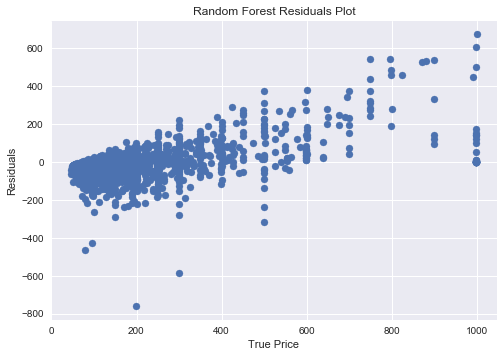

In [29]:
y_pred = rf.predict(X_test)
residuals = y_test - y_pred
plt.scatter(y_test, residuals)
plt.ylabel('Residuals')
plt.xlabel('True Price')
plt.title('Random Forest Residuals Plot')
plt.show()

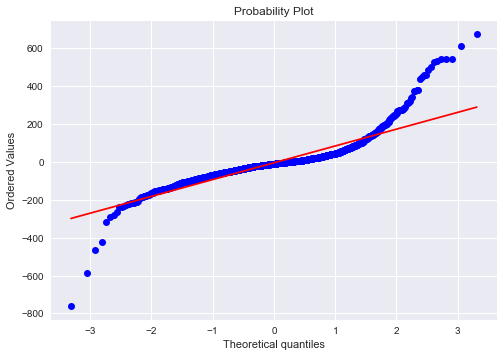

In [30]:
import scipy as sp
fig, ax = plt.subplots()
sp.stats.probplot(residuals, plot=ax, fit=True)
plt.show()

In [31]:
rf_feature_importances = pd.DataFrame([list(df.columns), rf.feature_importances_]).T
rf_feature_importances.sort_values(by=1, ascending=False).head(10)

,0,1
34,require_guest_phone_verification,0.346901
8,bathrooms,0.204982
21,availability_365,0.0560148
12,security_deposit,0.0461315
6,longitude,0.0325603
35,calculated_host_listings_count,0.0317153
36,reviews_per_month,0.0271919
2,host_total_listings_count,0.0216839
7,accommodates,0.0204402
5,latitude,0.0190629


## XGBoosting

In [32]:
xgb = XGBRegressor(random_state=42)
xgb.fit(X_train, y_train)
evaluate(xgb, X_test, y_test)

[13:29:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Test R^2: 0.709
MAE: $64.72
MAPE: 34.94%
SSE: 15301864.20
MSE: 10283.51
Accuracy = 65.06%


# TO-DO:
- hyperparameter turning of `XGBoost` Modeling
- code commenting
- create more visualizations of data
- further feature engineering to decrease MAE